### Pulling Sales Data from the Large File for each Company

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import os
import glob
import pickle
from collections import defaultdict

import seaborn as sns
sns.set()

In [2]:
client = Client(processes=True)
client

Client Scheduler: tcp://127.0.0.1:51468 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 15.98 GiB


In [270]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [6]:
main_dir             = "E:/TDI_Capstone_Data_Repo/main-repo"
analysis_dir         = "E:/TDI_Capstone_Data_Repo/main-repo/analysis_dir"
analysis_sales_data  = "E:/TDI_Capstone_Data_Repo/main-repo/analysis_dir/top50_sales_data"
dispo_sales_data_dir = "E:\\TDI_Capstone_Data_Repo\\main-repo\\dispo_sales_data_repo"
os.chdir(main_dir)
os.getcwd()

'F:\\TDI_Capstone_Data_Repo\\main-repo'

In [2]:
inv              = "E:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/*.csv"
labres           = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_labResults-Apr2021/*.csv"
salei0           = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems0/*.csv"
salei1           = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems1/*.csv"
labres_dir       = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_labResults-Apr2021/"
licensees_path   = "E:\\TDI_Capstone_Data_Repo\\main-repo\\Licensees_0\\Licensees_0.csv"
sales_dir        = "E:\\TDI_Capstone_Data_Repo\\Sales\\*.csv"
###################################################
#licensees_df = pd.read_csv(licensees_path, sep=',')
labres_date_cols = ['created_at','updated_at','tested_at','received_at']

In [3]:
def remove_unwanted_cols(path, cols_to_rm):
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(files[i])
        df = df.drop(cols_to_rm, axis=1)
        # save the column
        df.to_csv(files[i], index=False)

def datetime_to_date(path, col_to_conv):
    # Grab all .csv files in directory
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(files[i], error_bad_lines=False)
        # convert the string to a datetime
        df[col_to_conv] = pd.to_datetime(df[col_to_conv], format='%Y-%m-%d')
        # reduce the datetime to a date
        df[col_to_conv] = df[col_to_conv].dt.date
        # save the column
        df.to_csv(files[i], index=False)
        
def datetime_outlier_rm(datelist, date_threshold):
    counter = 0
    for i in tqdm(range(len(datelist)), desc="Progress"):
        if datelist[i] < date_threshold:
            counter += 1
    return(counter)

def sort_df_files(path, date_idx_col):
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        df = pd.read_csv(files[i])
        df = df.sort_values(by = date_idx_col)
        df.reset_index(inplace=True)
        del df['index']
        df.to_csv(files[i], index=False)
        
def individualfiles_datetime_to_date(list_dfs, col_to_conv):
    # Grab all .csv files in directory
    for i in tqdm(range(len(list_dfs)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(list_dfs[i], error_bad_lines=False)
        # convert the string to a datetime
        df[col_to_conv] = pd.to_datetime(df[col_to_conv], format='%Y-%m-%d')
        # reduce the datetime to a date
        df[col_to_conv] = df[col_to_conv].dt.date
        # save the column
        df.to_csv(list_dfs[i], index=False)
        
def pull_sales_data(list_mmeids, df_sales):
    for i in tqdm(range(len(list_mmeids)), desc="Progress"):
        df_sales[['global_id', 
                  'type', 
                  'sold_at', 'price_total', 
                  'status']][sales_df.mme_id == list_mmeids[i]].to_csv("sales_"+str(list_mmeids[i])+".csv", single_file=True, index=False)
        
def determine_shape_dfs(directory):
    shapes = []
    os.chdir(directory)
    files = os.listdir()
    for i in tqdm(range(len(files)), desc="Progress"):
        df = pd.read_csv(files[i])
        tmp = df.shape
        shapes.append(tmp)
    return(shapes)

def multiFile_valueCount_cols(directory, col2valCount):
    val_counts = []
    os.chdir(directory)
    files = os.listdir()
    for i in tqdm(range(len(files)), desc="Progress"):
        df = pd.read_csv(files[i])
        tmp = df[col2valCount].value_counts()
        val_counts.append(tmp)
    return(val_counts)

def compute_test_per_mme_id_saleitems(mme_ids_list, dask_df0, dask_df1):
    out = []
    for i in tqdm(range(len(mme_ids_list)), desc="Progress"):
        num_sales0 = dask.compute(dask_df0[dask_df0.mme_id == mme_ids_list[i]].shape)[0]
        num_sales1 = dask.compute(dask_df1[dask_df1.mme_id == mme_ids_list[i]].shape)[0]
        out.append((mme_ids_list[i], num_sales0[0] + num_sales1[0]))
    return out

def compute_test_per_mme_id_sales(mme_ids_list, dask_df0):
    out = []
    for i in tqdm(range(len(mme_ids_list)), desc="Progress"):
        num_sales0 = dask.compute(dask_df0[dask_df0.mme_id == mme_ids_list[i]].shape)[0]
        out.append((mme_ids_list[i], num_sales0[0]))
    return out

In [4]:
#si_date_cols = ['sold_at']
si0_df = dd.read_csv(salei0, sep=',', encoding = "utf-8", blocksize = '64MB')
si1_df = dd.read_csv(salei1, sep=',', encoding = "utf-8", blocksize = '64MB')

#labres_date_cols = ['created_at','updated_at','tested_at','received_at']
col_type_fixes = {'external_id': 'object'}
labres_df =  dd.read_csv(labres, sep=',', encoding = "utf-8", dtype = col_type_fixes, blocksize = '64MB')

#inv_date_cols = ['created_at', 'updated_at']
inv_df =  dd.read_csv(inv, sep=',', encoding = "utf-8", dtype = col_type_fixes, blocksize = '64MB')

sales_df = dd.read_csv(sales_dir, sep='\t', blocksize="64MB")

In [7]:
with open('top50_companies_mmeid_numTests_name.pkl', 'rb') as f:
    top50 = pickle.load(f)

In [8]:
top50

[(('WAWA1.MMIE', (2049, 35)), 'BLC'),
 (('WAWA1.MMBP', (2033, 35)), 'BINGCANNABIS'),
 (('WAWA1.MMO1', (1717, 35)), 'AMBER BRICK'),
 (('WAWA1.MM2S', (1708, 35)), 'NATURAL MYSTIC FARMS'),
 (('WAWA1.MMZ6', (1541, 35)), 'QUALITY BRAND'),
 (('WAWA1.MMV', (1470, 35)), 'AGRIJUANA'),
 (('WAWA1.MME0', (1411, 35)), 'W.O.W. INDUSTRIES'),
 (('WAWA1.MM88', (1405, 35)), 'VERDELUX CHOCOLATES'),
 (('WAWA1.MM6C', (1394, 35)), 'ALIS GROUP'),
 (('WAWA1.MM126', (1375, 35)), 'ROYALE LEISURE INDUSTRIES'),
 (('WAWA1.MMNY', (1359, 35)), 'BOGGY BOON'),
 (('WAWA1.MMVW', (1357, 35)), 'GREEN ACRE PHARMS'),
 (('WAWA1.MM1LE', (1307, 35)), 'MOLECULAR TESTING LABS'),
 (('WAWA1.MMBF', (1273, 35)), 'OMG SYKES'),
 (('WAWA1.MMWS', (1249, 35)), 'DOCTOR AND CROOK'),
 (('WAWA1.MMQX', (1127, 35)), 'PROPACWA'),
 (('WAWA1.MM1L6', (1123, 35)), 'Steep Hill Labs'),
 (('WAWA1.MM13R', (1087, 35)), 'KHUSH KUSH'),
 (('WAWA1.MM3X', (1050, 35)), 'NORTHWEST GROWN PRODUCTS'),
 (('WAWA1.MM9Y', (1048, 35)), 'ORGROW'),
 (('WAWA1.MMFY', (100

In [9]:
top50mmeid = [top50[i][0][0] for i in range(len(top50))]
print(top50mmeid)

['WAWA1.MMIE', 'WAWA1.MMBP', 'WAWA1.MMO1', 'WAWA1.MM2S', 'WAWA1.MMZ6', 'WAWA1.MMV', 'WAWA1.MME0', 'WAWA1.MM88', 'WAWA1.MM6C', 'WAWA1.MM126', 'WAWA1.MMNY', 'WAWA1.MMVW', 'WAWA1.MM1LE', 'WAWA1.MMBF', 'WAWA1.MMWS', 'WAWA1.MMQX', 'WAWA1.MM1L6', 'WAWA1.MM13R', 'WAWA1.MM3X', 'WAWA1.MM9Y', 'WAWA1.MMFY', 'WAWA1.MM171', 'WAWA1.MM1BE', 'WAWA1.MMYD', 'WAWA1.MM21', 'WAWA1.MMJ6', 'WAWA1.MMQN', 'WAWA1.MMIG', 'WAWA1.MMHW', 'WAWA1.MMBX', 'WAWA1.MMPM', 'WAWA1.MM14K', 'WAWA1.MMHI', 'WAWA1.MMS3', 'WAWA1.MMXD', 'WAWA1.MM129', 'WAWA1.MMCO', 'WAWA1.MMIY', 'WAWA1.MMDW', 'WAWA1.MM1S', 'WAWA1.MMZ9', 'WAWA1.MM1E9', 'WAWA1.MM8U', 'WAWA1.MMUZ', 'WAWA1.MMLW', 'WAWA1.MMMY', 'WAWA1.MMP0', 'WAWA1.MMCY', 'WAWA1.MMIX', 'WAWA1.MMLK']


In [10]:
with open('top50_mmeids.pkl', 'wb') as f:
    pickle.dump(top50mmeid, f)

In [11]:
with open('top50_mmeids.pkl', 'rb') as f:
    top50mmeid = pickle.load(f)

In [12]:
top50mmeid

['WAWA1.MMIE',
 'WAWA1.MMBP',
 'WAWA1.MMO1',
 'WAWA1.MM2S',
 'WAWA1.MMZ6',
 'WAWA1.MMV',
 'WAWA1.MME0',
 'WAWA1.MM88',
 'WAWA1.MM6C',
 'WAWA1.MM126',
 'WAWA1.MMNY',
 'WAWA1.MMVW',
 'WAWA1.MM1LE',
 'WAWA1.MMBF',
 'WAWA1.MMWS',
 'WAWA1.MMQX',
 'WAWA1.MM1L6',
 'WAWA1.MM13R',
 'WAWA1.MM3X',
 'WAWA1.MM9Y',
 'WAWA1.MMFY',
 'WAWA1.MM171',
 'WAWA1.MM1BE',
 'WAWA1.MMYD',
 'WAWA1.MM21',
 'WAWA1.MMJ6',
 'WAWA1.MMQN',
 'WAWA1.MMIG',
 'WAWA1.MMHW',
 'WAWA1.MMBX',
 'WAWA1.MMPM',
 'WAWA1.MM14K',
 'WAWA1.MMHI',
 'WAWA1.MMS3',
 'WAWA1.MMXD',
 'WAWA1.MM129',
 'WAWA1.MMCO',
 'WAWA1.MMIY',
 'WAWA1.MMDW',
 'WAWA1.MM1S',
 'WAWA1.MMZ9',
 'WAWA1.MM1E9',
 'WAWA1.MM8U',
 'WAWA1.MMUZ',
 'WAWA1.MMLW',
 'WAWA1.MMMY',
 'WAWA1.MMP0',
 'WAWA1.MMCY',
 'WAWA1.MMIX',
 'WAWA1.MMLK']

### Grab Top 50 Company Sales Data
- Top 50 companies are based on the amount of tests then sent to a testing facilies

In [15]:
os.chdir(analysis_sales_data)
print(os.getcwd())

E:\TDI_Capstone_Data_Repo\main-repo\analysis_dir\top50_sales_data


In [30]:
#pull_sales_data(top50mmeid, sales_df)
#os.chdir(main_dir)

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
top50_sales_shapes = determine_shape_dfs(analysis_sales_data)
print(top50_sales_shapes)

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

[(1843, 8), (718, 8), (1226, 8), (846, 8), (828, 8), (2867, 8), (1547, 8), (4563, 8), (1162, 8), (577, 8), (2400, 8), (1460, 8), (0, 8), (1602, 8), (1344, 8), (507, 8), (0, 8), (1624, 8), (1632, 8), (4814, 8), (1308, 8), (5193, 8), (4052, 8), (1423, 8), (202, 8), (1570, 8), (2924, 8), (2919, 8), (408, 8), (3408, 8), (1216, 8), (1237, 8), (271, 8), (4974, 8), (1718, 8), (1142, 8), (2970, 8), (2286, 8), (918, 8), (1710, 8), (1719, 8), (1469, 8), (1667, 8), (1807, 8), (1206, 8), (263, 8), (1787, 8), (2417, 8), (10972, 8), (2867, 8)]


In [22]:
individualfiles_datetime_to_date(os.listdir(analysis_sales_data), "sold_at")

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
df = pd.read_csv(os.listdir(analysis_sales_data)[1])
df

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
0,WAJ414395.SARB,2018-02-05 04:34:35,2018-02-05 04:34:35,NaN,wholesale,2018-02-04,1.55,sale
1,WAJ414395.SAQXI,2018-02-06 08:31:06,2018-02-06 08:31:06,2018-02-07 07:34:59,wholesale,2018-02-05,35.00,sale
2,WAJ414395.SA1U0R,2018-02-06 23:35:00,2018-02-06 23:35:00,NaN,wholesale,2018-02-06,35.00,sale
3,WAJ414395.SA1YO6,2018-02-07 01:53:45,2018-02-07 01:53:45,NaN,wholesale,2018-02-06,56.00,sale
4,WAJ414395.SA1YOB,2018-02-07 01:53:47,2018-02-07 01:53:47,NaN,wholesale,2018-02-06,56.00,sale
...,...,...,...,...,...,...,...,...
713,WAJ414395.SA24EPEE,2019-08-20 09:36:44,2019-08-20 09:36:44,NaN,wholesale,2019-08-19,6000.00,sale
714,WAJ414395.SA24VBY4,2019-08-27 05:53:45,2019-08-27 05:53:45,NaN,wholesale,2019-08-26,9000.00,sale
715,WAJ414395.SA25D956,2019-09-03 22:37:03,2019-09-03 22:37:03,NaN,wholesale,2019-09-02,9000.00,sale
716,WAJ414395.SA2QTXEC,2020-06-13 08:26:11,2020-06-13 08:26:11,NaN,wholesale,2020-06-11,55.60,sale


In [24]:
sort_df_files(analysis_sales_data, "sold_at")

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
valCounts_type = multiFile_valueCount_cols(analysis_sales_data, "type")

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
valCounts_type[0]

wholesale    1843
Name: type, dtype: int64

### Get the Dispensaries

In [5]:
df_lic = pd.read_csv(licensees_path)
df_lic

,global_id,created_at,updated_at,external_id,deleted_at,name,certificate_number,address1,address2,city,state_code,postal_code,country_code,phone,type,code,is_live,expired_at,suspended
0,WAWA1.MM1,1/1/1900 00:00,1/1/1900 00:00,1,NaN,WA State,1.000000e+00,NaN,NaN,NaN,NaN,NaN,US,NaN,state,WA1,True,NaN,False
1,WAWA1.MM2,1/1/1900 00:00,2/21/2018 07:47,1111,2/21/2018 07:47,LCB Grow,9.876544e+09,555 Brown St,NaN,Olympia,WA,98101,US,206-555-1212,cultivator,G892365,True,NaN,False
2,WAWA1.MM3,1/1/1900 00:00,2/21/2018 07:47,2222,2/21/2018 07:47,LCB Mfg,9.876544e+09,555 Brown St,NaN,Olympia,WA,98101,US,206-555-1212,production,M457698,True,NaN,False
3,WAWA1.MM4,1/1/1900 00:00,2/21/2018 07:47,3333,2/21/2018 07:47,LCB Retail,4.930938e+09,555 Brown St,NaN,Olympia,WA,98101,US,206-555-1212,dispensary,R773948,True,NaN,False
4,WAWA1.MM5,1/1/1900 00:00,2/21/2018 07:47,4444,2/21/2018 07:47,LCB Lab,4.930938e+09,555 Brown St,NaN,Tacoma,WA,98110,US,206-555-1213,lab,L883093,True,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,WAWA1.MM2C3,12/3/2020 18:08,1/5/2021 18:07,wa add,NaN,FAR WEST ENTERPRISE,6.033547e+08,4350 KAWECKI RD STE A,NaN,MALAGA,WA,988280000,USA,2066731984,cultivator,G416111,False,12/30/2018 16:00,True
2882,WAWA1.MM2C4,12/7/2020 18:07,1/5/2021 18:06,wa add,NaN,GOOBIE'S DOOBIES,6.035765e+08,28680 MAPLE VALLEY BLACK,NaN,MAPLE VALLEY,WA,980388193,USA,2534595741,dispensary,R421953,False,1/30/2021 16:00,True
2883,WAWA1.MM2C5,12/18/2020 18:13,1/5/2021 18:07,wa add,NaN,GREEN RIDGE PRODUCTIONS,6.045694e+08,1578 MOORE ST,NaN,SEDRO WOOLLEY,WA,982047523,USA,3603036623,cultivator_production,J417227,False,1/30/2021 16:00,True
2884,WAWA1.MM2C6,12/21/2020 18:12,1/5/2021 18:06,wa add,NaN,KUSHMAN,6.027086e+08,11110 MUKILTEO SPEEDWAY,NaN,MUKILTEO,WA,982755450,USA,4254441575,dispensary,R415287,False,3/30/2021 17:00,True


In [6]:
df_lic.type.value_counts()

cultivator_production    1427
dispensary                767
production                346
cultivator                238
co-op                      34
transporter                28
lab                        23
tribe                      21
state                       1
Name: type, dtype: int64

- 767 dispensaries in the State of Washington
- Grab their `mme_id`
- Create Separate sales files from the main sales data
- Hopefully this will not take more than a couple hours
- Find the best dispos?  Grab the top 50 and then move to make some visualizations?

In [7]:
df_lic[df_lic['type'] == 'dispensary']['global_id']

3         WAWA1.MM4
120      WAWA1.MM3D
121      WAWA1.MM3E
122      WAWA1.MM3F
124      WAWA1.MM3H
           ...     
2871    WAWA1.MM2BT
2873    WAWA1.MM2BV
2882    WAWA1.MM2C4
2884    WAWA1.MM2C6
2885    WAWA1.MM2C7
Name: global_id, Length: 767, dtype: object

In [19]:
dispos_ids = list(_)

In [21]:
with open('dispos_ids.pkl', 'wb') as f:
    pickle.dump(dispos_ids, f)

In [9]:
with open('dispos_ids.pkl', 'rb') as f:
    dispos_ids = pickle.load(f)

In [10]:
dispos_ids

['WAWA1.MM4',
 'WAWA1.MM3D',
 'WAWA1.MM3E',
 'WAWA1.MM3F',
 'WAWA1.MM3H',
 'WAWA1.MM3I',
 'WAWA1.MM3L',
 'WAWA1.MM3P',
 'WAWA1.MM3R',
 'WAWA1.MM3S',
 'WAWA1.MM3V',
 'WAWA1.MM3W',
 'WAWA1.MM42',
 'WAWA1.MM48',
 'WAWA1.MM4A',
 'WAWA1.MM4B',
 'WAWA1.MM4C',
 'WAWA1.MM4D',
 'WAWA1.MM4E',
 'WAWA1.MM4F',
 'WAWA1.MM4H',
 'WAWA1.MM4J',
 'WAWA1.MM4K',
 'WAWA1.MM4M',
 'WAWA1.MM4N',
 'WAWA1.MM4S',
 'WAWA1.MM4U',
 'WAWA1.MM4V',
 'WAWA1.MM4Y',
 'WAWA1.MM4Z',
 'WAWA1.MM50',
 'WAWA1.MM51',
 'WAWA1.MM52',
 'WAWA1.MM55',
 'WAWA1.MM57',
 'WAWA1.MM5C',
 'WAWA1.MM5D',
 'WAWA1.MM5G',
 'WAWA1.MM5H',
 'WAWA1.MM5I',
 'WAWA1.MM5J',
 'WAWA1.MM5K',
 'WAWA1.MM5N',
 'WAWA1.MM5P',
 'WAWA1.MM5Q',
 'WAWA1.MM5V',
 'WAWA1.MM5W',
 'WAWA1.MM5Z',
 'WAWA1.MM62',
 'WAWA1.MM66',
 'WAWA1.MM6J',
 'WAWA1.MM6V',
 'WAWA1.MM6W',
 'WAWA1.MM6Y',
 'WAWA1.MM6Z',
 'WAWA1.MM74',
 'WAWA1.MM7C',
 'WAWA1.MM7G',
 'WAWA1.MM7T',
 'WAWA1.MM80',
 'WAWA1.MM83',
 'WAWA1.MM89',
 'WAWA1.MM8T',
 'WAWA1.MM90',
 'WAWA1.MM96',
 'WAWA1.MM9A',
 'WAWA1.MM9

In [23]:
sales_df.head()

,global_id,created_at,updated_at,external_id,deleted_at,type,mme_id,user_id,area_id,sold_by_user_id,sold_at,price_total,status
0,WAJ412252.SA1,2018-01-31 22:34:37,2018-01-31 22:34:37,NaN,2018-02-01 06:35:04,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
1,WAJ412252.SA2,2018-01-31 22:35:06,2018-01-31 22:35:06,NaN,2018-02-01 06:35:30,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
2,WAJ412252.SA3,2018-01-31 22:35:32,2018-01-31 22:35:32,NaN,2018-02-01 06:37:22,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
3,WAJ412252.SA4,2018-01-31 22:37:23,2018-01-31 22:37:23,NaN,2018-02-01 08:11:08,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
4,WAJ412252.SA5,2018-01-31 22:58:26,2018-01-31 22:58:26,NaN,2018-02-01 08:41:33,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,1701.0,sale


In [26]:
all_mmeid_sales_count = dask.compute(sales_df.mme_id.value_counts())

In [17]:
os.chdir(main_dir)

In [34]:
with open('all_mmeid_sales_count.pkl', 'wb') as f:
    pickle.dump(all_mmeid_sales_count[0], f)

In [18]:
with open('all_mmeid_sales_count.pkl', 'rb') as f:
    all_mmeid_sales_count = pickle.load(f)

In [20]:
len(list(all_mmeid_sales_count.index))

1736

In [54]:
dispo_sales_dict = {ids: 0 for ids in dispos_ids}
for i in tqdm(range(len(dispos_ids)), desc="Progress"):
    list_to_scan = list(all_mmeid_sales_count[0].index)
    if dispos_ids[i] in list_to_scan:
        dispo_sales_dict[dispos_ids[i]] += all_mmeid_sales_count[0][dispos_ids[i]]

Progress:   0%|          | 0/767 [00:00<?, ?it/s]

In [55]:
dispo_sales_dict

{'WAWA1.MM4': 0,
 'WAWA1.MM3D': 225041,
 'WAWA1.MM3E': 1442852,
 'WAWA1.MM3F': 1181977,
 'WAWA1.MM3H': 839873,
 'WAWA1.MM3I': 221642,
 'WAWA1.MM3L': 171032,
 'WAWA1.MM3P': 577424,
 'WAWA1.MM3R': 222148,
 'WAWA1.MM3S': 39,
 'WAWA1.MM3V': 163989,
 'WAWA1.MM3W': 802330,
 'WAWA1.MM42': 377550,
 'WAWA1.MM48': 0,
 'WAWA1.MM4A': 1694108,
 'WAWA1.MM4B': 58241,
 'WAWA1.MM4C': 1295357,
 'WAWA1.MM4D': 1146272,
 'WAWA1.MM4E': 285649,
 'WAWA1.MM4F': 606635,
 'WAWA1.MM4H': 824276,
 'WAWA1.MM4J': 317840,
 'WAWA1.MM4K': 2753287,
 'WAWA1.MM4M': 1268988,
 'WAWA1.MM4N': 539572,
 'WAWA1.MM4S': 2046022,
 'WAWA1.MM4U': 231372,
 'WAWA1.MM4V': 1080352,
 'WAWA1.MM4Y': 38918,
 'WAWA1.MM4Z': 881687,
 'WAWA1.MM50': 457541,
 'WAWA1.MM51': 294710,
 'WAWA1.MM52': 241151,
 'WAWA1.MM55': 196804,
 'WAWA1.MM57': 2496350,
 'WAWA1.MM5C': 312247,
 'WAWA1.MM5D': 21508,
 'WAWA1.MM5G': 688163,
 'WAWA1.MM5H': 132958,
 'WAWA1.MM5I': 0,
 'WAWA1.MM5J': 733241,
 'WAWA1.MM5K': 917688,
 'WAWA1.MM5N': 248665,
 'WAWA1.MM5P': 282378,
 

In [56]:
with open('dispo_sales_dict.pkl', 'wb') as f:
    pickle.dump(dispo_sales_dict, f)

In [15]:
sorted_dispo_sale_counts = sorted(dispo_sales_dict.items(), key=lambda x:x[1], reverse=True)

NameError: name 'dispo_sales_dict' is not defined

In [63]:
with open('sorted_dispo_sale_counts.pkl', 'wb') as f:
    pickle.dump(sorted_dispo_sale_counts, f)

In [21]:
with open('sorted_dispo_sale_counts.pkl', 'rb') as f:
    sorted_dispo_sale_counts = pickle.load(f)

In [12]:
top50_dispos_bySales = sorted_dispo_sale_counts[:50]
top50_dispos_bySales

[('WAWA1.MM5W', 4115427),
 ('WAWA1.MM4K', 2753287),
 ('WAWA1.MM57', 2496350),
 ('WAWA1.MMFO', 2050629),
 ('WAWA1.MM4S', 2046022),
 ('WAWA1.MMEV', 2021644),
 ('WAWA1.MM9P', 2004670),
 ('WAWA1.MM18J', 1998583),
 ('WAWA1.MM11S', 1952254),
 ('WAWA1.MM13P', 1837754),
 ('WAWA1.MMQY', 1796638),
 ('WAWA1.MM4A', 1694108),
 ('WAWA1.MMIP', 1668019),
 ('WAWA1.MMFE', 1626727),
 ('WAWA1.MMM9', 1582216),
 ('WAWA1.MM1E3', 1569766),
 ('WAWA1.MMCF', 1567541),
 ('WAWA1.MMIQ', 1539330),
 ('WAWA1.MMDN', 1524274),
 ('WAWA1.MM1VW', 1483753),
 ('WAWA1.MMEJ', 1458407),
 ('WAWA1.MMLP', 1449544),
 ('WAWA1.MM3E', 1442852),
 ('WAWA1.MM12U', 1418026),
 ('WAWA1.MM9R', 1411433),
 ('WAWA1.MM5Z', 1376306),
 ('WAWA1.MMCD', 1349387),
 ('WAWA1.MMNZ', 1311758),
 ('WAWA1.MM12M', 1310466),
 ('WAWA1.MM4C', 1295357),
 ('WAWA1.MMKG', 1294804),
 ('WAWA1.MM17J', 1274085),
 ('WAWA1.MM10X', 1269294),
 ('WAWA1.MM4M', 1268988),
 ('WAWA1.MMZW', 1246246),
 ('WAWA1.MMBH', 1211445),
 ('WAWA1.MM13G', 1208106),
 ('WAWA1.MM18Q', 1207174),
 

In [24]:
len(sorted_dispo_sale_counts)

767

In [26]:
dispo_mme_id_list = [sorted_dispo_sale_counts[i][0] for i in range(len(sorted_dispo_sale_counts))]

In [27]:
dispo_mme_id_list

['WAWA1.MM5W',
 'WAWA1.MM4K',
 'WAWA1.MM57',
 'WAWA1.MMFO',
 'WAWA1.MM4S',
 'WAWA1.MMEV',
 'WAWA1.MM9P',
 'WAWA1.MM18J',
 'WAWA1.MM11S',
 'WAWA1.MM13P',
 'WAWA1.MMQY',
 'WAWA1.MM4A',
 'WAWA1.MMIP',
 'WAWA1.MMFE',
 'WAWA1.MMM9',
 'WAWA1.MM1E3',
 'WAWA1.MMCF',
 'WAWA1.MMIQ',
 'WAWA1.MMDN',
 'WAWA1.MM1VW',
 'WAWA1.MMEJ',
 'WAWA1.MMLP',
 'WAWA1.MM3E',
 'WAWA1.MM12U',
 'WAWA1.MM9R',
 'WAWA1.MM5Z',
 'WAWA1.MMCD',
 'WAWA1.MMNZ',
 'WAWA1.MM12M',
 'WAWA1.MM4C',
 'WAWA1.MMKG',
 'WAWA1.MM17J',
 'WAWA1.MM10X',
 'WAWA1.MM4M',
 'WAWA1.MMZW',
 'WAWA1.MMBH',
 'WAWA1.MM13G',
 'WAWA1.MM18Q',
 'WAWA1.MM13M',
 'WAWA1.MM3F',
 'WAWA1.MMCT',
 'WAWA1.MM4D',
 'WAWA1.MMC9',
 'WAWA1.MMC8',
 'WAWA1.MM12V',
 'WAWA1.MM66',
 'WAWA1.MM4V',
 'WAWA1.MMBE',
 'WAWA1.MM1FJ',
 'WAWA1.MM1OE',
 'WAWA1.MMQ9',
 'WAWA1.MMMH',
 'WAWA1.MM167',
 'WAWA1.MM5K',
 'WAWA1.MMXZ',
 'WAWA1.MM1GV',
 'WAWA1.MM4Z',
 'WAWA1.MM11Y',
 'WAWA1.MMZY',
 'WAWA1.MMEC',
 'WAWA1.MM3H',
 'WAWA1.MMVV',
 'WAWA1.MMAP',
 'WAWA1.MM4H',
 'WAWA1.MM3W',
 'WAWA1

In [28]:
len(dispo_mme_id_list)

767

- Now that I have gotten the top50 dispensaries by the number of sales, I will collect them in their own .csv files/dataframes for visualization and analysis.
- Should work for how I set up everything with the wholesale companies

In [35]:
os.chdir(dispo_sales_data_dir)
print(os.getcwd())
pull_sales_data(dispo_mme_id_list[80:81], sales_df)
os.chdir(main_dir)

F:\TDI_Capstone_Data_Repo\main-repo\dispo_sales_data_repo


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
os.chdir(dispo_sales_data_dir)
files = os.listdir()

In [32]:
def dispo_sales_cleanUp(path):
    # grab all the files in the path
    files = os.listdir(path)
    for i in tqdm(range(len(files)), desc="Progress"):
        df = pd.read_csv(files[i], error_bad_lines=False)
        #df = df[df['status'] == 'sale']
        df.drop(df[df['price_total'] == "sale"].index, inplace = True)
        df["price_total"] = pd.to_numeric(df["price_total"], downcast="float")
        df["sold_at"] = pd.to_datetime(df["sold_at"], format='%Y-%m-%d')
        # reduce the datetime to a date
        df["sold_at"] = df["sold_at"].dt.date
        df = df[(df["sold_at"] > datetime.date(2017, 12, 31)) & (df["sold_at"] < datetime.date(2021, 1, 1))]
        df.to_csv(files[i], index=False)

In [36]:
os.chdir(dispo_sales_data_dir)

In [37]:
dispo_sales_cleanUp(dispo_sales_data_dir)

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

ValueError: time data 2019-10- doesn't match format specified

In [217]:
%%time
df = pd.read_csv(files[0], error_bad_lines=False)
df.drop(df[df['price_total'] == "sale"].index, inplace = True)
df["sold_at"] = pd.to_datetime(df["sold_at"], format='%Y-%m-%d')
# reduce the datetime to a date
df["sold_at"] = df["sold_at"].dt.date

<decorator-gen-55>:2: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


Wall time: 17.5 s


In [218]:
df.head()

,global_id,type,sold_at,price_total,status
0,WAR415229.SAGJDN,retail_medical,2017-11-05,0.0,sale
1,WAR415229.SAGJEK,retail_medical,2017-11-05,0.0,sale
2,WAR415229.SAGJFQ,retail_medical,2017-11-05,0.0,sale
3,WAR415229.SAGJGR,retail_medical,2017-11-05,0.0,sale
4,WAR415229.SAGK6Z,retail_medical,2017-11-05,0.0,sale


In [219]:
df.shape

(4078237, 5)

In [220]:
df.type.value_counts()

retail_medical         3737079
retail_recreational     341157
retail                       1
Name: type, dtype: int64

In [147]:
df

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
7628,WAR415229.SAYH2O,2018-02-14 17:25:13,2018-02-14 17:25:13,NaN,retail_medical,2018-01-02,0.0,sale
7629,WAR415229.SAYH3A,2018-02-14 17:25:13,2018-02-14 17:25:13,NaN,retail_medical,2018-01-02,0.0,sale
7630,WAR415229.SAYH3V,2018-02-14 17:25:15,2018-02-14 17:25:15,NaN,retail_medical,2018-01-02,0.0,sale
7631,WAR415229.SAYH4D,2018-02-14 17:25:17,2018-02-14 17:25:17,NaN,retail_medical,2018-01-02,0.0,sale
7632,WAR415229.SAYH53,2018-02-14 17:25:16,2018-02-14 17:25:16,NaN,retail_medical,2018-01-02,0.0,sale
...,...,...,...,...,...,...,...,...
4065437,WAR415229.SA37H9IG,2021-01-06 14:36:19,2021-01-06 14:36:19,NaN,retail_recreational,2021-01-06,34.24,sale
4065438,WAR415229.SA37H9J9,2021-01-06 14:37:20,2021-01-06 14:37:20,NaN,retail_recreational,2021-01-06,10.48,sale
4065439,WAR415229.SA37H9MA,2021-01-06 14:40:36,2021-01-06 14:40:36,NaN,retail_recreational,2021-01-06,48.8,sale
4065440,WAR415229.SA37HA3X,2021-01-06 14:54:15,2021-01-06 14:54:15,NaN,retail_recreational,2021-01-06,60.72,sale


In [148]:
df["price_total"] = pd.to_numeric(df["price_total"], downcast="float")
df.dtypes

<ipython-input-148-09dc22141831>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_total"] = pd.to_numeric(df["price_total"], downcast="float")


global_id       object
created_at      object
updated_at      object
deleted_at      object
type            object
sold_at         object
price_total    float32
status          object
dtype: object

In [149]:
df

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
7628,WAR415229.SAYH2O,2018-02-14 17:25:13,2018-02-14 17:25:13,NaN,retail_medical,2018-01-02,0.000000,sale
7629,WAR415229.SAYH3A,2018-02-14 17:25:13,2018-02-14 17:25:13,NaN,retail_medical,2018-01-02,0.000000,sale
7630,WAR415229.SAYH3V,2018-02-14 17:25:15,2018-02-14 17:25:15,NaN,retail_medical,2018-01-02,0.000000,sale
7631,WAR415229.SAYH4D,2018-02-14 17:25:17,2018-02-14 17:25:17,NaN,retail_medical,2018-01-02,0.000000,sale
7632,WAR415229.SAYH53,2018-02-14 17:25:16,2018-02-14 17:25:16,NaN,retail_medical,2018-01-02,0.000000,sale
...,...,...,...,...,...,...,...,...
4065437,WAR415229.SA37H9IG,2021-01-06 14:36:19,2021-01-06 14:36:19,NaN,retail_recreational,2021-01-06,34.240002,sale
4065438,WAR415229.SA37H9J9,2021-01-06 14:37:20,2021-01-06 14:37:20,NaN,retail_recreational,2021-01-06,10.480000,sale
4065439,WAR415229.SA37H9MA,2021-01-06 14:40:36,2021-01-06 14:40:36,NaN,retail_recreational,2021-01-06,48.799999,sale
4065440,WAR415229.SA37HA3X,2021-01-06 14:54:15,2021-01-06 14:54:15,NaN,retail_recreational,2021-01-06,60.720001,sale


In [160]:
#df = df.set_index("sold_at")
df_time_series = df.query("price_total > 0").groupby(["sold_at"])["price_total"].sum()
df_time_series_mean = df.query("price_total > 0").groupby(["sold_at"])["price_total"].mean()

In [162]:
df_time_series_mean

sold_at
2018-01-31    24.885061
2018-02-01    27.377117
2018-02-02    27.112888
2018-02-03    22.731709
2018-02-04    24.579029
                ...    
2021-01-02    35.538734
2021-01-03    32.503490
2021-01-04    32.845383
2021-01-05    37.907749
2021-01-06    32.885662
Name: price_total, Length: 1071, dtype: float32

In [237]:
df_time_series

sold_at
2018-01-31    21563.00
2018-02-01    26913.80
2018-02-02    22542.26
2018-02-03    13111.24
2018-02-04    17353.13
                ...   
2020-12-27     4817.41
2020-12-28     7058.61
2020-12-29     7925.68
2020-12-30    10213.84
2020-12-31     9180.95
Name: price_total, Length: 1059, dtype: float64

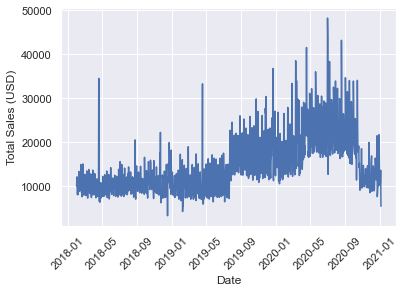

In [163]:
df_time_series.plot()
#df_time_series_mean.plot()

plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
#plt.title("BLC Total Daily Sales")
plt.xticks(rotation = 45)
plt.show()

In [264]:
df

sold_at
2018-01-07        0.00
2018-01-14        0.00
2018-01-21        0.00
2018-01-28        0.00
2018-02-04    51645.62
                ...   
2020-12-06    81428.97
2020-12-13    82618.51
2020-12-20    88407.02
2020-12-27    85432.93
2021-01-03    63935.60
Freq: W-SUN, Name: price_total, Length: 157, dtype: float64

In [265]:
df = pd.read_csv(files[0], error_bad_lines=False)
df['sold_at'] = df['sold_at'].astype('datetime64[ns]')
#df = df.set_index('sold_at').resample('W')['price_total'].sum()

In [269]:
df["type"].value_counts()

retail_medical         1464127
retail_recreational     339345
Name: type, dtype: int64

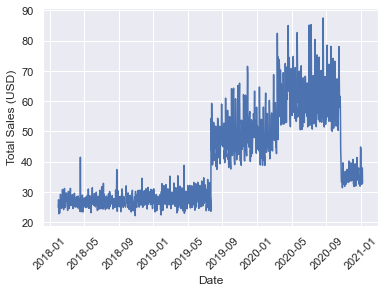

In [164]:
df_time_series_mean.plot()

plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
#plt.title("BLC Total Daily Sales")
plt.xticks(rotation = 45)
plt.show()

In [154]:
tmp = pd.DataFrame(df_time_series)

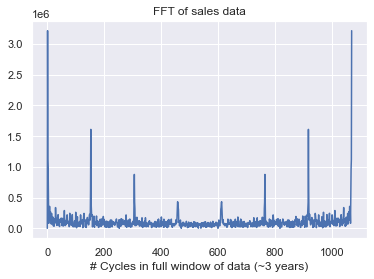

In [155]:
import scipy.fft

fft = scipy.fft.fft((tmp.price_total - tmp.price_total.mean()).values)
plt.plot(np.abs(fft))
plt.title("FFT of sales data")
plt.xlabel('# Cycles in full window of data (~3 years)');

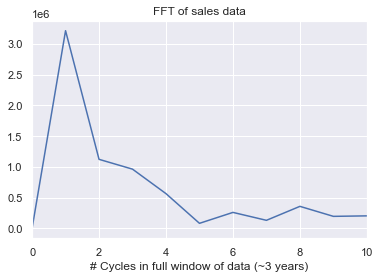

In [157]:
plt.plot(np.abs(fft))
plt.title("FFT of sales data")
plt.xlabel('# Cycles in full window of data (~3 years)')
plt.xlim([0,10]);

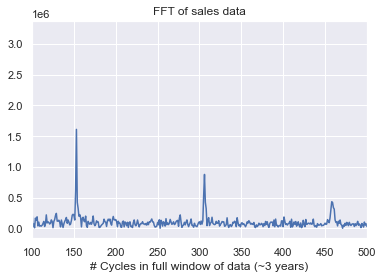

In [158]:
plt.plot(np.abs(fft))
plt.title("FFT of sales data")
plt.xlabel('# Cycles in full window of data (~3 years)')
plt.xlim([100,500]);

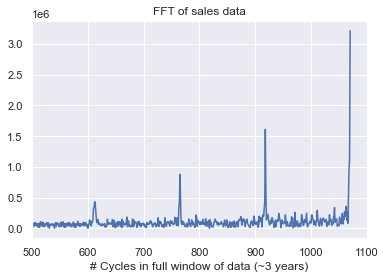

In [159]:
plt.plot(np.abs(fft))
plt.title("FFT of sales data")
plt.xlabel('# Cycles in full window of data (~3 years)')
plt.xlim([500,1100]);

Cleaning the data up for use in the streamlit application
- convert the `sold_at` column to a date (%Y-%m-%d)
- save the files
- drop bad rows, conditioning on `price_total`
- convert `price_total` to a float (from string object)
- remove `price_total` that are less than 0

In [169]:
os.chdir(dispo_sales_data_dir)
print(os.getcwd())
print(os.listdir())
print(len(os.listdir()))

F:\TDI_Capstone_Data_Repo\main-repo\dispo_sales_data_repo
['sales_WAWA1.MM5W.csv', 'sales_WAWA1.MM4K.csv', 'sales_WAWA1.MM57.csv', 'sales_WAWA1.MMFO.csv', 'sales_WAWA1.MM4S.csv', 'sales_WAWA1.MMEV.csv', 'sales_WAWA1.MM9P.csv', 'sales_WAWA1.MM18J.csv', 'sales_WAWA1.MM11S.csv', 'sales_WAWA1.MM13P.csv', 'sales_WAWA1.MMQY.csv']
11


In [184]:
df = pd.read_csv(os.listdir()[2], error_bad_lines=False)

In [173]:
df.head()

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
0,WAR425539.SAZ2,2018-02-05 20:32:33,2018-02-05 20:32:33,NaN,retail_medical,2018-01-31 16:00:00,6.84,sale
1,WAR425539.SAZ3,2018-02-05 20:32:33,2018-02-05 20:32:33,NaN,retail_medical,2018-01-31 16:00:00,6.84,sale
2,WAR425539.SAZ4,2018-02-05 20:32:33,2018-02-05 20:32:33,NaN,retail_medical,2018-01-31 16:00:00,6.84,sale
3,WAR425539.SAZ5,2018-02-05 20:32:34,2018-02-05 20:32:34,NaN,retail_medical,2018-01-31 16:00:00,8.21,sale
4,WAR425539.SAZ6,2018-02-05 20:32:34,2018-02-05 20:32:34,NaN,retail_medical,2018-01-31 16:00:00,6.84,sale


In [187]:
df = df[df['status'] == 'sale']
df.drop(df[df['price_total'] == "sale"].index, inplace = True)
df["price_total"] = pd.to_numeric(df["price_total"], downcast="float")
df["sold_at"] = pd.to_datetime(df["sold_at"], format='%Y-%m-%d')
# reduce the datetime to a date
df["sold_at"] = df["sold_at"].dt.date

C:\Users\Jeff\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-187-ae9419b7b934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_total"] = pd.to_numeric(df["price_total"], downcast="float")
<ipython-input-187-ae9419b7b934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [188]:
df

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
0,WAR413683.SAZEA,2018-02-06 11:20:05,2018-02-06 11:20:05,NaN,retail_medical,2018-01-31,13.580000,sale
1,WAR413683.SAZEB,2018-02-06 11:20:06,2018-02-06 11:20:06,NaN,retail_medical,2018-01-31,13.580000,sale
2,WAR413683.SAZEC,2018-02-06 11:20:05,2018-02-06 11:20:05,NaN,retail_medical,2018-01-31,6.790000,sale
3,WAR413683.SAZED,2018-02-06 11:20:06,2018-02-06 11:20:06,NaN,retail_medical,2018-01-31,9.500000,sale
4,WAR413683.SAZEE,2018-02-06 11:20:07,2018-02-06 11:20:07,NaN,retail_medical,2018-01-31,7.470000,sale
...,...,...,...,...,...,...,...,...
2496314,WAR413683.SA37F8J5,2021-01-06 01:15:19,2021-01-06 01:15:19,NaN,retail_recreational,2021-01-04,16.270000,sale
2496315,WAR413683.SA37F8JH,2021-01-06 01:15:23,2021-01-06 01:15:23,NaN,retail_recreational,2021-01-04,16.270000,sale
2496316,WAR413683.SA37F8JO,2021-01-06 01:15:26,2021-01-06 01:15:27,NaN,retail_recreational,2021-01-04,2.710000,sale
2496317,WAR413683.SA37F8JX,2021-01-06 01:15:29,2021-01-06 01:15:29,NaN,retail_recreational,2021-01-04,2.710000,sale


In [19]:
os.getcwd()

'F:\\TDI_Capstone_Data_Repo\\main-repo'

In [226]:
df = pd.read_csv(os.listdir()[1])
df = df.set_index("sold_at")
df_time_series      = df.query("price_total > 0 & status == 'sale'").groupby(["sold_at"])["price_total"].sum()
df_time_series_mean = df.query("price_total > 0 & status == 'sale'").groupby(["sold_at"])["price_total"].mean()
df_time_series_std  = df.query("price_total > 0 & status == 'sale'").groupby(["sold_at"])["price_total"].std()

In [225]:
df

,global_id,type,sold_at,price_total,status
0,WAR425539.SAZ2,retail_medical,2018-01-31,6.84,sale
1,WAR425539.SAZ3,retail_medical,2018-01-31,6.84,sale
2,WAR425539.SAZ4,retail_medical,2018-01-31,6.84,sale
3,WAR425539.SAZ5,retail_medical,2018-01-31,8.21,sale
4,WAR425539.SAZ6,retail_medical,2018-01-31,6.84,sale
...,...,...,...,...,...
2751900,WAR425539.SA377HFA,retail_recreational,2020-07-29,-82.08,return
2751901,WAR425539.SA377P51,retail_recreational,2020-12-31,20.52,sale
2751902,WAR425539.SA379QTW,retail_recreational,2020-07-29,-82.08,return
2751903,WAR425539.SA37CHYW,retail_recreational,2020-07-29,-82.08,return


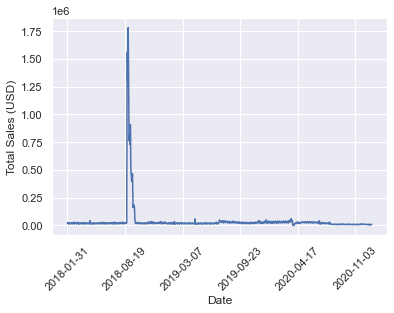

In [227]:
df_time_series.plot()
#df_time_series_mean.plot()

plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
#plt.title("BLC Total Daily Sales")
plt.xticks(rotation = 45)
plt.show()

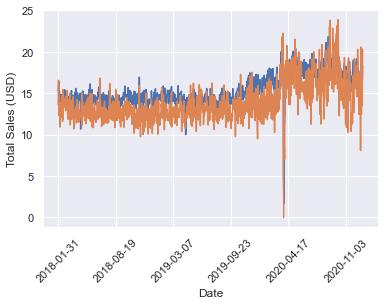

In [228]:
#df_time_series.plot()
df_time_series_mean.plot()
df_time_series_std.plot()

plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
#plt.title("BLC Total Daily Sales")
plt.xticks(rotation = 45)
plt.show()

In [198]:
df_time_series > 100000

sold_at
2018-01-25    False
2018-01-26    False
2018-01-27    False
2018-01-28    False
2018-01-29    False
              ...  
2020-12-31    False
2021-01-01    False
2021-01-02    False
2021-01-03    False
2021-01-04    False
Name: price_total, Length: 1076, dtype: bool

In [229]:
license_df = pd.read_csv(licensees_path)

In [231]:
license_df[['global_id', 'name']]

,global_id,name
0,WAWA1.MM1,WA State
1,WAWA1.MM2,LCB Grow
2,WAWA1.MM3,LCB Mfg
3,WAWA1.MM4,LCB Retail
4,WAWA1.MM5,LCB Lab
...,...,...
2881,WAWA1.MM2C3,FAR WEST ENTERPRISE
2882,WAWA1.MM2C4,GOOBIE'S DOOBIES
2883,WAWA1.MM2C5,GREEN RIDGE PRODUCTIONS
2884,WAWA1.MM2C6,KUSHMAN


In [234]:
license_df[license_df['global_id'].isin(dispo_mme_id_list[:11])]

,global_id,created_at,updated_at,external_id,deleted_at,name,certificate_number,address1,address2,city,state_code,postal_code,country_code,phone,type,code,is_live,expired_at,suspended
163,WAWA1.MM4K,1/1/1900 00:00,1/5/2021 18:06,329,NaN,CASCADE KROPZ,603365603.0,19127 SMOKEY POINT BLVD BLDG 1,NaN,ARLINGTON,WA,982234264,US,3606595422,dispensary,R425539,True,1/30/2022 16:00,False
171,WAWA1.MM4S,1/1/1900 00:00,1/5/2021 18:06,335,NaN,420 HOLIDAY,603359238.0,2028 10TH AVE,NaN,LONGVIEW,WA,986324007,US,3607033103,dispensary,R415526,True,12/30/2021 16:00,False
186,WAWA1.MM57,1/1/1900 00:00,1/5/2021 18:06,349,NaN,HERBAL NATION,603489660.0,19302 BOTHELL EVERETT HWY,NaN,BOTHELL,WA,980127113,US,4254861111,dispensary,R413683,True,3/30/2021 17:00,False
211,WAWA1.MM5W,1/1/1900 00:00,1/5/2021 18:06,373,NaN,POT ZONE,603353868.0,1703 SE SEDGWICK RD,STE 113,PORT ORCHARD,WA,983669599,US,2533127280,dispensary,R415229,True,12/30/2021 16:00,False
348,WAWA1.MM9P,1/1/1900 00:00,1/5/2021 18:06,535,NaN,THE GREEN DOOR,603419626.0,28120 HWY 410 E UNIT A8,NaN,BUCKLEY,WA,983218482,US,2532248299,dispensary,R415410,True,7/30/2021 17:00,False
534,WAWA1.MMEV,1/1/1900 00:00,1/5/2021 18:06,739,NaN,TREEHOUSE CLUB,603420335.0,14421 E TRENT AVE,NaN,SPOKANE VALLEY,WA,992161392,US,5094132169,dispensary,R413369,True,7/30/2021 17:00,False
563,WAWA1.MMFO,1/1/1900 00:00,1/5/2021 18:06,770,NaN,EMERALD LEAVES,603561521.0,2702 6TH AVE,NaN,TACOMA,WA,984067213,US,2064825627,dispensary,R413363,True,11/29/2021 16:00,False
969,WAWA1.MMQY,1/1/1900 00:00,1/5/2021 18:06,1257,NaN,DESTINATION HIGHWAY 420,603453957.0,1225 HOLLIS ST,NaN,BREMERTON,WA,983103611,US,3606278754,dispensary,R414503,True,11/29/2021 16:00,False
1359,WAWA1.MM11S,1/1/1900 00:00,1/5/2021 18:06,1862,NaN,KITSAP CANNABIS 2,603560955.0,1762 VILLAGE LN SE,NaN,PORT ORCHARD,WA,983662644,US,3608658092,dispensary,R421359,True,11/29/2021 16:00,False
1428,WAWA1.MM13P,1/1/1900 00:00,1/5/2021 18:06,1977,NaN,PRC,604586837.0,23221 EDMONDS WAY STE A,STE A,EDMONDS,WA,980260000,US,4253432272,dispensary,R415198,True,3/30/2021 17:00,False


In [263]:
string = "420 HOLIDAY"
license_df[license_df["name"] == string]["global_id"].item()

'WAWA1.MM4S'

In [32]:
dispo_mme_id_list[11]

'WAWA1.MM4A'

'F:\\TDI_Capstone_Data_Repo\\main-repo\\dispo_sales_data_repo'